# Real tensor to Fourier domain with Hermitian symmetry

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util

%matplotlib inline
%load_ext autoreload 
%autoreload 2

In [72]:
size = 3*[10]
n_rep = 1000
spatial = jr.normal(jr.key(0), (n_rep,*size))
# spatial /= ((size)**.5)**3
i_toplot = 0

def plot_fourier(fourier, i_toplot=0):
    n_rep, *size = fourier.shape
    plt.figure(figsize=(7,3))
    plt.subplot(121)
    plt.pcolormesh(fourier.real[0,:,:,i_toplot])
    plt.title("real")
    plt.colorbar()
    plt.subplot(122)
    plt.pcolormesh(fourier.imag[0,:,:,i_toplot])
    plt.title("imag")
    plt.colorbar();
    print("shape:",fourier.shape)
    print("n_unique comp: ", jnp.unique(fourier[0]).shape)
    print("n_unique real: ", jnp.unique(fourier.real[0]).shape)
    print("n_unique imag: ", jnp.unique(jnp.abs(fourier.imag)[0]).shape)
    print("n_unique total: ", jnp.unique(fourier.real[0]).shape[0] + jnp.unique(jnp.abs(fourier.imag)[0]).shape[0], 
          "vs.", size[0]*size[1]*(2*(size[2]-1)), "+1 because of zero")

    all, rea, ima = (jnp.abs(fourier)**2).mean(0), (fourier.real**2).mean(0), (fourier.imag**2).mean(0)
    plt.figure(figsize=(10,6))
    plt.subplot(231)
    plt.pcolormesh(all[:,:,i_toplot])
    plt.title("var abs")
    plt.colorbar()
    plt.subplot(232)
    plt.pcolormesh(rea[:,:,i_toplot])
    plt.title("var real")
    plt.colorbar()
    plt.subplot(233)
    plt.pcolormesh(ima[:,:,i_toplot])
    plt.title("var imag")
    plt.colorbar()

    j_toplot = 3
    C_abs = jnp.cov(jnp.abs(fourier)[:,j_toplot,:,0].T, jnp.abs(fourier)[:,:,j_toplot,0].T)
    C_real = jnp.cov(fourier.real[:,j_toplot,:,0].T, fourier.real[:,:,j_toplot,0].T)
    C_imag = jnp.cov(fourier.imag[:,j_toplot,:,0].T, fourier.imag[:,:,j_toplot,0].T)

    fourier = fourier.reshape(n_rep, -1)
    C_abs = jnp.cov(jnp.abs(fourier).T, jnp.abs(fourier).T)
    C_real = jnp.cov(fourier.real.T, fourier.real.T)
    C_imag = jnp.cov(fourier.imag.T, fourier.imag.T)
    plt.subplot(234)
    plt.imshow(C_abs)
    plt.title("cov abs")
    plt.colorbar()
    plt.subplot(235)
    plt.imshow(C_real)
    plt.title("cov real")
    plt.colorbar()
    plt.subplot(236)
    plt.imshow(C_imag)
    plt.title("cov imag")
    plt.colorbar()
    plt.tight_layout()

shape: (1000, 10, 10, 6)
n_unique comp:  (600,)
n_unique real:  (545,)
n_unique imag:  (533,)
n_unique total:  1078 vs. 1000 +1 because of zero


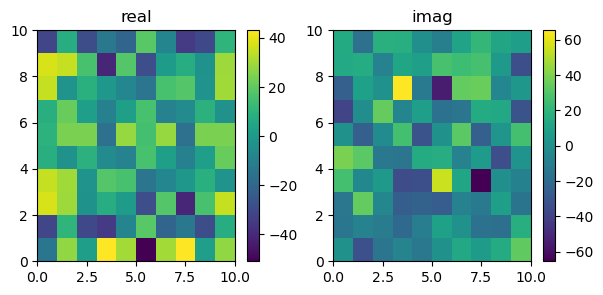

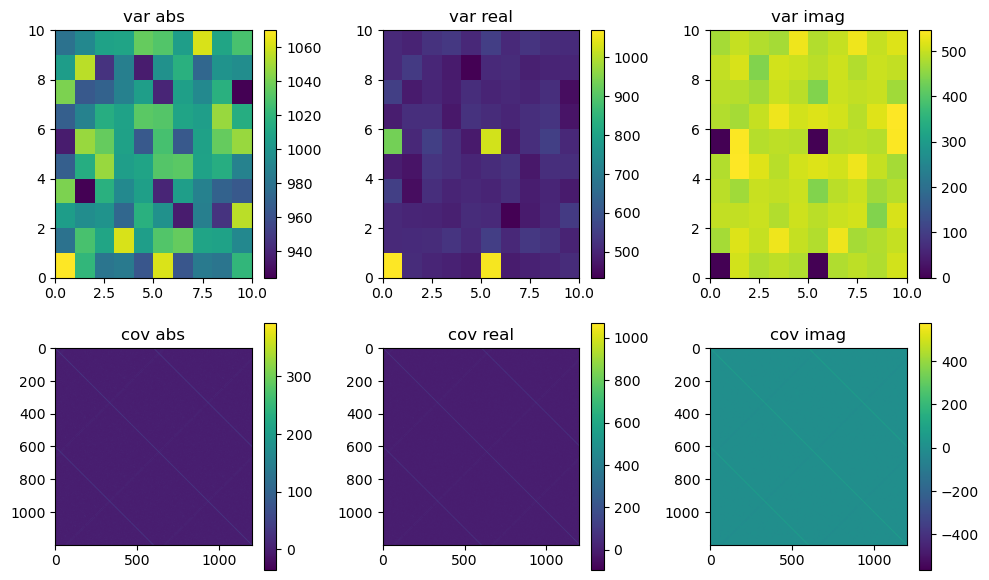

In [73]:
fourier = vmap(jnp.fft.rfftn)(spatial)
plot_fourier(fourier, i_toplot)

shape: (1000, 64, 64, 17)
n_unique comp:  (69632,)
n_unique real:  (65252,)
n_unique imag:  (65261,)
n_unique total:  130513 vs. 131072 +1 because of zero


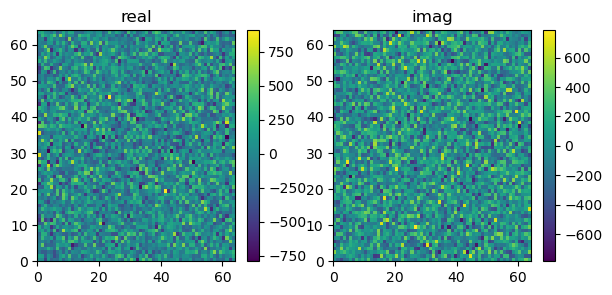

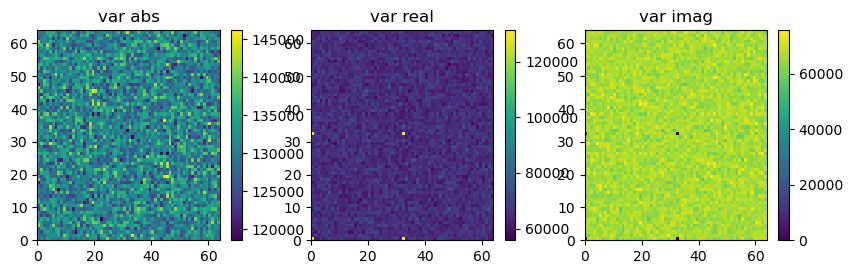

In [5]:
from montecosmo.utils import r2rfftn
fourier = vmap(r2rfftn)(spatial)
plot_fourier(fourier, i_toplot)

In [6]:
import math

@jit
def genrete_realx_gaussian_field_3d_k_mask(randns, dtype=jnp.float64, cdtype=jnp.complex128):
    """
    randns is an array with nc^3 standard normal vars
    """
    #import numpy as jnp    # change to jax after! fixme
    
    randns = randns.flatten()
    nc = round(randns.shape[0]**(1./3))
    
    # due to G*(f) = G(-f) symmetry, the return value will have shape nc,nc/2+1 (assuming d even)
    n = round(nc/2)+1
    
    ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype) 
    
    # grid for masking
    #grid0, grid1, grid2 = jnp.meshgrid(jnp.arange(nc), jnp.arange(nc), jnp.arange(n))
     
    # fill all non k2=0 and nyq voxels with complex number  (n-1 is nyq)
    s = (nc, nc, n-2)
    m = math.prod(s)
    
    #mask = (1 <= grid2) * (grid2 < n-1)
    pads = ((0,0), (0,0), (1,1))    # need to pad r such that it has same shape as mask, and aligns with the 1s.  # fixme, can completely remove mask!
    
    i = 0         # running index for taking dofs    for neatness, always have i= above r=
    r = randns[i:i+m].reshape(s)    # do sqrt2 just before end
    i += m
    
    ret += jnp.pad(r, pads)
    
    r = randns[i:i+m].reshape(s) * 1j
    i += m
    
    ret += jnp.pad(r, pads)
    
    # fill k2=0 nyq>k0>0  (note use of n in firt index now) only want to fill half and then will conj flip by sim.
    # we have a choice to reflect in axis 0 or 1. we chose to reflect in 1 first, 
    # so compared to 2d we just have an extra :, at the beginnign.
    # but then we'll have anthertep to reflect in 0 dimension
    # to keep track of rands easily will do reflection conj by hand.
    s = (nc, n-2, 1)
    m = math.prod(s)
    for b in [0,n-1]:                                # same methodology for when grid2=0 or nyq, o loop
        
        r = randns[i:i+m].reshape(s)
        i += m
        
        pads = [None, None, None]   # save space by updating pads[i] depending on line.
        if   b == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
        elif b == n-1: pads[2] = (n-1,0) 
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps: now we will need to pad AND mask
        # padding ofc needed for shape as above, and mask needed because we want to only reflect certain subregions of r each time)
        #pads[1] = (n,0)   # same for all of these reflections
        
        
        # real part reflections. recall r is unpadded, so simple ::-1 (in 1 index) followed by appropriate padding and 0 index works!
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (0,nc-1)
        ret += jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret += jnp.pad(r[n-1,::-1,b][None,:,None], pads) 
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (n,0)
        ret += jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret += jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
        # now do same for imaginary part
        r = randns[i:i+m].reshape(s) * 1j
        i += m
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps. - for conj
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b)
        pads[0] = (0,nc-1)
        ret -= jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret -= jnp.pad(r[n-1,::-1,b][None,:,None], pads)
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b)
        pads[0] = (n,0)
        ret -= jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret -= jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
    # now we fill the remaining lines across the 0 axis
    s = (n-2, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            r = randns[i:i+m].reshape(s)
            i += m
            
            pads = [None, None, None]   # save space by updating pads[i] depending on line.
            if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
            elif b2 == n-1: pads[2] = (n-1,0) 
            if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
            elif b1 == n-1: pads[1] = (n-1,n-2) 

            # real
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret += jnp.pad(r[::-1, b1, b2][:,None,None], pads)         #n-2:0:-1
            
            
            r = randns[i:i+m].reshape(s) * 1j
            i += m
            
            # im
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret -= jnp.pad(r[::-1, b1, b2][:,None,None], pads)
    
    # divide everyhting by sqrt(2) before doing real components
    ret /= jnp.sqrt(2)
    
    # now fill in real parts
    s = (1, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            for b0 in [0, n-1]:
                
                pads = [None, None, None]   # save space by updating pads[i] depending on line.
                if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
                elif b2 == n-1: pads[2] = (n-1,0) 
                if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
                elif b1 == n-1: pads[1] = (n-1,n-2) 
                if   b0 == 0:   pads[0] = (0,nc-1)   # pads[0] is the same throughout loop
                elif b0 == n-1: pads[0] = (n-1,n-2) 

                r = randns[i:i+m].reshape(s)
                i += m
    
                #mask = (grid0 == b0) * (grid1 == b1) * (grid2 == b2)
                ret += jnp.pad(r, pads)
            
    assert(i == nc**3)
    
    return ret #jnp.asarray(ret)


In [7]:
fourier = vmap(genrete_realx_gaussian_field_3d_k_mask)(spatial)
plot_fourier(fourier, i_toplot)

/tmp/ipykernel_3032229/4017080917.py:16: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype)


TypeError: cannot reshape array of shape (1022,) (size 1022) into shape (51, 25, 1) (size 1275)

In [14]:
def id_r2rfftn(mesh_size, part="real"):
    """
    Return indices and weights to make a Gaussian tensor of size ``mesh_size`` (3D)
    distributed as the real Fourier transform of a Gaussian tensor.
    Handle the Hermitian symmetry, specificaly at middle faces, edges, and points.
    """
    mesh_size = np.array(mesh_size)
    sx, sy, sz = mesh_size
    # assert sx%2 == sy%2 == sz%2 == 0, "dimensions lengths must be even."
    hx, hy, hz = mesh_size//2
    kmesh_size = (sx, sy, hz+1)
    weights = jnp.ones(kmesh_size) * (mesh_size.prod() / 2)**.5
    id = jnp.zeros((3,*kmesh_size), dtype=int)
    xyz = jnp.indices(mesh_size)

    if part == "imag":
        slix, sliy, sliz = slice(hx+1, None), slice(hy+1, None), slice(hz+1, None)
        slixr, sliyr = slice(None, hx, -1), slice(None, hy, -1)
    else:
        slix, sliy, sliz = slice(1,hx), slice(1,hy), slice(1,hz)
        slixr, sliyr = slice(1,hx,-1), slice(1,hy,-1)
    id = id.at[...,1:-1].set( xyz[...,sliz] )
        
    for k in [0,hz]: # two faces
        id = id.at[...,1:hy,k].set(xyz[...,sliy,k])
        id = id.at[...,1:,hy+1:,k].set(xyz[...,:0:-1,sliyr,k])
        id = id.at[...,0,hy+1:,k].set(xyz[...,0,sliyr,k]) # handle the border
        if part == "imag":
            weights = weights.at[:,hy+1:,k].multiply(-1)

        for j in [0,hy]: # two edges per faces
            id = id.at[...,1:hx,j,k].set(xyz[...,slix,j,k])
            id = id.at[...,hx+1:,j,k].set(xyz[...,slix,j,k][...,::-1])
            if part == "imag":
                weights = weights.at[hx+1:,j,k].multiply(-1)

            for i in [0,hx]: # two points per edges
                id = id.at[...,i,j,k].set(xyz[...,i,j,k])
                if part == "imag":
                    weights = weights.at[i,j,k].multiply(0)
                else:
                    weights = weights.at[i,j,k].multiply(2**.5)
    
    return id, weights


def id_rfftn2r(mesh_size, part="real"):
    """
    Return indices and weights to make a Gaussian tensor of size ``mesh_size`` (3D)
    distributed as the real Fourier transform of a Gaussian tensor.
    Handle the Hermitian symmetry, specificaly at middle faces, edges, and points.
    """
    mesh_size = np.array(mesh_size)
    sx, sy, sz = mesh_size
    # assert sx%2 == sy%2 == sz%2 == 0, "dimensions lengths must be even."
    hx, hy, hz = mesh_size//2
    kmesh_size = (sx, sy, hz+1)
    weights = jnp.ones(kmesh_size) * (mesh_size.prod() / 2)**.5
    id = jnp.zeros((3,*mesh_size), dtype=int)
    xyz = jnp.indices(kmesh_size)

    if part == "imag":
        slix, sliy, sliz = slice(hx+1, None), slice(hy+1, None), slice(hz+1, None)
    else:
        slix, sliy, sliz = slice(1,hx), slice(1,hy), slice(1,hz)
    id = id.at[...,sliz].set( xyz[...,1:-1] )
        
    for k in [0,hz]: # two faces
        id = id.at[...,sliy,k].set(xyz[...,1:hy,k])
        id = id.at[...,1:,sliy,k].at[...,::-1,::-1].set(xyz[...,1:,hy+1:,k])
        id = id.at[...,0,sliy,k][...,::-1].set(xyz[...,0,hy+1:,k]) # handle the border
        if part == "imag":
            weights = weights.at[:,hy+1:,k].multiply(-1)

        for j in [0,hy]: # two edges per faces
            id = id.at[...,slix,j,k].set(xyz[...,1:hx,j,k])
            id = id.at[...,slix,j,k][...,::-1].set(xyz[...,hx+1:,j,k])
            if part == "imag":
                weights = weights.at[hx+1:,j,k].multiply(-1)

            for i in [0,hx]: # two points per edges
                id = id.at[...,i,j,k].set(xyz[...,i,j,k])
                if part == "imag":
                    weights = weights.at[i,j,k].multiply(0)
                else:
                    weights = weights.at[i,j,k].multiply(2**.5)
    
    return id, weights



def r2rfftn(mesh):
    """
    Make a Gaussian tensor (3D) distributed as the real Fourier transform of a Gaussian tensor.
    """
    mesh_size = mesh.shape
    id_real, w_real = id_r2rfftn(mesh_size, part="real")
    id_imag, w_imag = id_r2rfftn(mesh_size, part="imag")
    return mesh[*id_real] * w_real + 1j * mesh[*id_imag] * w_imag

# def rfftn2r(kmesh):
#     """
#     Make a real Fourier transform of a Gaussian tensor (3D) distributed as a Gaussian tensor.
#     """
#     mesh_size = kmesh.shape
#     mesh_size = *mesh_size[:2], 2*(mesh_size[2]-1)
#     print(mesh_size)
#     id_real, w_real = id_rfftn(mesh_size, part="real")
#     id_imag, w_imag = id_rfftn(mesh_size, part="imag")
#     # return id_real, jnp.argsort(id_real),
    
#     mesh = jnp.zeros(mesh_size)
#     print(jnp.argsort(id_real, axis=0).shape)
#     mesh = mesh.at[jnp.argsort(id_real, axis=0)].set(kmesh.real / w_real)
#     mesh = mesh.at[jnp.argsort(id_imag, axis=0)].set(kmesh.imag / w_imag)
#     return mesh

def rfftn2r(kmesh):
    """
    Make a real Fourier transform of a Gaussian tensor (3D) distributed as a Gaussian tensor.
    """
    mesh_size = kmesh.shape
    mesh_size = *mesh_size[:2], 2*(mesh_size[2]-1)
    print(mesh_size)
    id_real, w_real = id_rfftn2r(mesh_size, part="real")
    id_imag, w_imag = id_rfftn2r(mesh_size, part="imag")
    # return id_real, jnp.argsort(id_real),
    
    mesh = jnp.zeros(mesh_size)
    print(jnp.argsort(id_real, axis=0).shape)
    mesh = mesh.at[jnp.argsort(id_real, axis=0)].set(kmesh.real / w_real)
    mesh = mesh.at[jnp.argsort(id_imag, axis=0)].set(kmesh.imag / w_imag)
    return mesh

In [57]:
# def id_rfftn(mesh_size, part="real"):
#     """
#     Return indices and weights to make a Gaussian tensor of size ``mesh_size`` (3D)
#     distributed as the real Fourier transform of a Gaussian tensor.
#     Handle the Hermitian symmetry, specificaly at middle faces, edges, and points.
#     """
#     mesh_size = np.array(mesh_size)
#     sx, sy, sz = mesh_size
#     # assert sx%2 == sy%2 == sz%2 == 0, "dimensions lengths must be even."
#     hx, hy, hz = mesh_size//2
#     kmesh_size = (sx, sy, hz+1)
#     weights = jnp.ones(kmesh_size) * (mesh_size.prod() / 2)**.5
#     id = jnp.zeros((3,*kmesh_size), dtype=int)
#     xyz = jnp.indices(mesh_size)

#     if part == "imag":
#         slix, sliy, sliz = slice(hx+1, None), slice(hy+1, None), slice(hz+1, None)
#     else:
#         slix, sliy, sliz = slice(1,hx), slice(1,hy), slice(1,hz)
#     id = id.at[...,1:-1].set( xyz[...,sliz] )
        
#     for k in [0,hz]: # two faces
#         id = id.at[...,1:hy,k].set(xyz[...,sliy,k])
#         id = id.at[...,1:,hy+1:,k].set(xyz[...,1:,sliy,k][...,::-1,::-1])
#         id = id.at[...,0,hy+1:,k].set(xyz[...,0,sliy,k][...,::-1]) # handle the border
#         if part == "imag":
#             weights = weights.at[:,hy+1:,k].multiply(-1)

#         for j in [0,hy]: # two edges per faces
#             id = id.at[...,1:hx,j,k].set(xyz[...,slix,j,k])
#             id = id.at[...,hx+1:,j,k].set(xyz[...,slix,j,k][...,::-1])
#             if part == "imag":
#                 weights = weights.at[hx+1:,j,k].multiply(-1)

#             for i in [0,hx]: # two points per edges
#                 id = id.at[...,i,j,k].set(xyz[...,i,j,k])
#                 if part == "imag":
#                     weights = weights.at[i,j,k].multiply(0)
#                 else:
#                     weights = weights.at[i,j,k].multiply(2**.5)
    
#     return id, weights


def id_rfftn(mesh_size, part="real"):
    """
    Return indices and weights to make a Gaussian tensor of size ``mesh_size`` (3D)
    distributed as the real Fourier transform of a Gaussian tensor.
    Handle the Hermitian symmetry, specificaly at middle faces, edges, and points.
    """
    mesh_size = np.array(mesh_size)
    sx, sy, sz = mesh_size
    # assert sx%2 == sy%2 == sz%2 == 0, "dimensions lengths must be even."
    hx, hy, hz = mesh_size//2
    kmesh_size = (sx, sy, hz+1)
    weights = np.ones(kmesh_size) * (mesh_size.prod() / 2)**.5
    id = np.zeros((3,*kmesh_size), dtype=int)
    xyz = np.indices(mesh_size)

    if part == "imag":
        slix, sliy, sliz = slice(hx+1, None), slice(hy+1, None), slice(hz+1, None)
    else:
        slix, sliy, sliz = slice(1,hx), slice(1,hy), slice(1,hz)
    id[...,1:-1] = xyz[...,sliz]
        
    for k in [0,hz]: # two faces
        id[...,1:hy,k] = xyz[...,sliy,k]
        id[...,1:,hy+1:,k] = xyz[...,1:,sliy,k][...,::-1,::-1]
        id[...,0,hy+1:,k] = xyz[...,0,sliy,k][...,::-1] # handle the border
        if part == "imag":
            weights[:,hy+1:,k] *= -1

        for j in [0,hy]: # two edges per faces
            id[...,1:hx,j,k] = xyz[...,slix,j,k]
            id[...,hx+1:,j,k] = xyz[...,slix,j,k][...,::-1]
            if part == "imag":
                weights[hx+1:,j,k] *= -1

            for i in [0,hx]: # two points per edges
                id[...,i,j,k] = xyz[...,i,j,k]
                if part == "imag":
                    weights[i,j,k] *= 0
                else:
                    weights[i,j,k] *= 2**.5
    
    return id, weights


@jit
def r2rfftn(mesh):
    """
    Make a Gaussian tensor (3D) distributed as the real Fourier transform of a Gaussian tensor.
    """
    mesh_size = mesh.shape
    id_real, w_real = id_rfftn(mesh_size, part="real")
    id_imag, w_imag = id_rfftn(mesh_size, part="imag")
    return mesh[*id_real] * w_real + 1j * mesh[*id_imag] * w_imag

@jit
def rfftn2r(kmesh):
    """
    Make a real Fourier transform of a Gaussian tensor (3D) distributed as a Gaussian tensor.
    """
    mesh_size = kmesh.shape
    mesh_size = *mesh_size[:2], 2*(mesh_size[2]-1)
    id_real, w_real = id_rfftn(mesh_size, part="real")
    id_imag, w_imag = id_rfftn(mesh_size, part="imag")
    
    mesh = jnp.zeros(mesh_size)
    mesh = mesh.at[*id_imag].set(kmesh.imag / w_imag)
    mesh = mesh.at[*id_real].set(kmesh.real / w_real)
    return mesh

In [58]:
fourier = vmap(r2rfftn)(spatial)
spatial2 = vmap(rfftn2r)(fourier)
from numpy.testing import assert_allclose
assert_allclose(spatial, spatial2, rtol=1e-3)
# plot_fourier(fourier, i_toplot)